# Romero Stats analysis

This notebook tries to regress the metrics created by Romero and Al. in ther paper Shocking the Crowd: The Effect of Censorship Shocks on Chinese Wikipedia.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
import statsmodels.stats.api as sms

In [2]:
DATA_PATH = '/dlabdata1/turkish_wiki/processed_data'

## Regressions

In [3]:
# Read Romero metric Data
shock_level = pd.read_csv(f"{DATA_PATH}/shock_level.csv", index_col=0)
gini = pd.read_csv(f"{DATA_PATH}/gini.csv", index_col=0)
level_of_activity = pd.read_csv(f"{DATA_PATH}/level_of_activity.csv",  index_col=0)
conflict = pd.read_csv(f"{DATA_PATH}/conflict.csv")

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
# Merge all the metrics together for regression analysis
metrics_df = pd.merge(shock_level, level_of_activity, on = 'page_id', how= 'outer')
metrics_df = pd.merge(metrics_df, gini, on = 'page_id', how= 'outer')
metrics_df = pd.merge(metrics_df, conflict, on = 'page_id', how= 'outer')

In [5]:
# Filter articles for regression (requirement: More than 2 editors in the pre-block period)
metrics_df = metrics_df[metrics_df['nprea'] >= 2]

# Indicatior variable for regression iblock -> Does the article have editor in the preblock period that got blocked
metrics_df['iblock'] = (metrics_df['blocked_user_edits_count'] > 0).astype(int)

# Square of block ratio for polynomial fitting
metrics_df['blocked_ratio_sq'] = metrics_df['blocked_ratio']**2

In [6]:
metrics_df.head()

,page_id,all_edits_count,blocked_user_edits_count,blocked_ratio,preblock_edit_count,block_edit_count,delta,eprea,eposta,gprea,...,cdelta,preblock_reverts,preblock_edits,block_reverts,block_edits,preblock_revert_rate,block_revert_rate,change,iblock,blocked_ratio_sq
0,5,2.0,1.0,0.500000,2.0,0.0,-1.000000,"Counter({800643: 1, 113659: 1})",NaN,0.000000,...,NaN,1.0,2.0,0.0,0.0,0.500000,NaN,NaN,1,0.250000
1,10,247.0,74.0,0.299595,247.0,27.0,-0.890688,"Counter({208697: 105, 21244: 13, 86010: 9, 905...","Counter({573665: 6, 208697: 3, 331285: 3, 9050...",0.625091,...,-0.173980,62.0,247.0,4.0,27.0,0.251012,0.148148,-0.102864,1,0.089757
2,16,2.0,0.0,0.000000,2.0,0.0,-1.000000,"Counter({93111: 1, 96765: 1})",NaN,0.000000,...,NaN,0.0,2.0,0.0,0.0,0.000000,NaN,NaN,0,0.000000
3,22,56.0,21.0,0.375000,56.0,6.0,-0.892857,"Counter({748781: 17, 770797: 6, 536500: 3, 597...","Counter({748781: 3, 573665: 2, 90501: 1})",0.470497,...,-0.168044,8.0,56.0,2.0,6.0,0.142857,0.333333,0.190476,1,0.140625
4,24,90.0,58.0,0.644444,90.0,15.0,-0.833333,"Counter({365127: 29, 166490: 11, 1572: 8, 9050...","Counter({90501: 4, 573665: 2, 1024836: 2, 1369...",0.562007,...,-0.019209,17.0,90.0,2.0,15.0,0.188889,0.133333,-0.055556,1,0.415309


### 1) Change in Activity, Centralization and Conflict controlled by the number of preblock editors and indicator of having a user blocked
This first part doesn't deal with the ratio of blocked users as the level of the shock but more simply by the indicator variable iblock, which is 1 if a user that edited the given article in the preblock period got blocked during the ban and 0 if none of the users got blocked. 
We fit the variables below using OLS controling for the number of editors in the preblock period:
* delta: Relative change of the number of edits between the block and preblock period.
* cdelta: Change of the gini coefficient, measuring centrality of edits.
* change: Change of the revert rate between block and preblock period

In [7]:
results = []

In [8]:
for variable in ['delta', 'cdelta', 'change']:
    mod = smf.ols(formula=f'{variable} ~ iblock + nprea',  data=metrics_df)
    res = mod.fit()
    results.append(res)

In [9]:
for elem in results:
    print(elem.summary())

                            OLS Regression Results                            
Dep. Variable:                  delta   R-squared:                       0.042
Model:                            OLS   Adj. R-squared:                  0.042
Method:                 Least Squares   F-statistic:                     4733.
Date:                Tue, 08 Jun 2021   Prob (F-statistic):               0.00
Time:                        20:13:53   Log-Likelihood:            -3.1736e+05
No. Observations:              218059   AIC:                         6.347e+05
Df Residuals:                  218056   BIC:                         6.348e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0620      0.004     17.313      0.0

In [12]:
summary_table = pd.DataFrame(index = ['Intercept', 'I_block', 'N_preblock_editors', 'R^2'], columns = ['Activity', 'Centralization', 'Conflict'])

In [13]:
for idx, result in enumerate(results):
    summary_table.iloc[:-1, idx] = result.params.values
    summary_table.iloc[-1, idx] = result.rsquared

In [14]:
summary_table

,Activity,Centralization,Conflict
Intercept,0.061975,-0.0351,-0.01797
I_block,-0.37832,0.011329,-0.02849
N_preblock_editors,-0.012729,0.000088,-0.002864
R^2,0.041604,0.000358,0.02115


The summary table shows that having users blocked leads to a decrease in activity and in conflict, while it increases centralization

### 2) Change in Activity, Centralization and Conflict controlled by the number of preblock editors and the ratio of blocked users

In [15]:
results = []
quad_results = []

In [16]:
for variable in ['delta', 'cdelta', 'change']:
    mod = smf.ols(formula=f'{variable} ~ blocked_ratio + nprea',  data=metrics_df[metrics_df['all_edits_count'] > 0])
    res = mod.fit()
    results.append(res)
    mod = smf.ols(formula=f'{variable} ~ blocked_ratio + blocked_ratio_sq + nprea',  data=metrics_df[metrics_df['all_edits_count'] > 0])
    res = mod.fit()
    quad_results.append(res)

In [17]:
for elem in results:
    print(elem.summary())

                            OLS Regression Results                            
Dep. Variable:                  delta   R-squared:                       0.043
Model:                            OLS   Adj. R-squared:                  0.043
Method:                 Least Squares   F-statistic:                     4952.
Date:                Tue, 08 Jun 2021   Prob (F-statistic):               0.00
Time:                        20:13:55   Log-Likelihood:            -3.1715e+05
No. Observations:              218059   AIC:                         6.343e+05
Df Residuals:                  218056   BIC:                         6.343e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.0302      0.003      9.116

In [18]:
summary_table = pd.DataFrame(index = ['Intercept', 'blocked_ratio', 'N_preblock_editors', 'R^2'], columns = ['Activity', 'Centralization', 'Conflict'])
quad_summary_table = pd.DataFrame(index = ['Intercept', 'blocked_ratio', 'blocked_ratio_sq', 'N_preblock_editors', 'R^2'], columns = ['Activity', 'Centralization', 'Conflict'])

In [19]:
for idx, result in enumerate(results):
    summary_table.iloc[:-1, idx] = result.params.values
    summary_table.iloc[-1, idx] = result.rsquared
for idx, result in enumerate(quad_results):
    quad_summary_table.iloc[:-1, idx] = result.params.values
    quad_summary_table.iloc[-1, idx] = result.rsquared

In [20]:
display(summary_table)
display(quad_summary_table)

,Activity,Centralization,Conflict
Intercept,0.03023,-0.031224,-0.024885
blocked_ratio,-0.67734,0.010888,-0.032809
N_preblock_editors,-0.016944,0.000199,-0.003242
R^2,0.043444,0.000128,0.017201


,Activity,Centralization,Conflict
Intercept,0.028789,-0.039262,-0.018997
blocked_ratio,-0.645179,0.184653,-0.184946
blocked_ratio_sq,-0.042875,-0.254521,0.226178
N_preblock_editors,-0.017072,-0.000224,-0.002773
R^2,0.043454,0.002508,0.023521


The quadratic fit improves the predictive power.

We have yet the same conclusion as above. 

As the ratio of the blocked users increase, activity and conflict decreases while the centralization increases.

## Fit metrics without dividing before and after
The Romero paper combines the metrics in a relative change or change metric and does not try to predict what happens in the block period based on the values of the metrics in the pre-block period which is quite strange and which results in a loss of information. Below, I try to do the same without the relative changes but by fitting the metrics in the block period directly with the control variables and the pre-block values of the same metric as an additional control.


### 1) Change in Activity, Centralization and Conflict controlled by the number of preblock editors and indicator of having a user blocked


In [32]:
results = []

In [33]:
for variable in [('block_edits', 'preblock_edits'), ('normalized_gposta', 'normalized_gprea'), ('block_revert_rate', 'preblock_revert_rate')]:
    mod = smf.ols(formula=f'{variable[0]} ~ iblock + {variable[1]} + nprea',  data=metrics_df)
    res = mod.fit()
    results.append(res)

In [34]:
for elem in results:
    print(elem.summary())

                            OLS Regression Results                            
Dep. Variable:            block_edits   R-squared:                       0.252
Model:                            OLS   Adj. R-squared:                  0.252
Method:                 Least Squares   F-statistic:                 2.450e+04
Date:                Tue, 08 Jun 2021   Prob (F-statistic):               0.00
Time:                        20:26:01   Log-Likelihood:            -7.2837e+05
No. Observations:              218059   AIC:                         1.457e+06
Df Residuals:                  218055   BIC:                         1.457e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          2.7093      0.024    113.

In [39]:
summary_table = pd.DataFrame(index = ['Intercept', 'I_block', 'Preblock_metric', 'N_preblock_editors', 'R^2'], columns = ['Activity', 'Centralization', 'Conflict'])

In [40]:
for idx, result in enumerate(results):
    summary_table.iloc[:-1, idx] = result.params.values
    summary_table.iloc[-1, idx] = result.rsquared

In [41]:
summary_table

,Activity,Centralization,Conflict
Intercept,2.709273,0.837122,0.013706
I_block,-0.666447,-0.00707,0.007923
Preblock_metric,0.114482,0.005028,0.116636
N_preblock_editors,0.281144,-0.000935,0.002215
R^2,0.252115,0.001677,0.046469


### 2) Change in Activity, Centralization and Conflict controlled by the number of preblock editors and the ratio of blocked users


In [42]:
results = []
quad_results = []

In [43]:
for variable in [('block_edits', 'preblock_edits'), ('normalized_gposta', 'normalized_gprea'), ('block_revert_rate', 'preblock_revert_rate')]:
    mod = smf.ols(formula=f'{variable[0]} ~ blocked_ratio + {variable[1]} + nprea',  data=metrics_df)
    res = mod.fit()
    results.append(res)
    mod = smf.ols(formula=f'{variable[0]} ~ blocked_ratio +  blocked_ratio_sq + {variable[1]} + nprea',  data=metrics_df[metrics_df['all_edits_count'] > 0])
    res = mod.fit()
    quad_results.append(res)

In [46]:
for elem in results:
    print(elem.summary())
for elem in quad_results:
    print(elem.summary())

                            OLS Regression Results                            
Dep. Variable:            block_edits   R-squared:                       0.261
Model:                            OLS   Adj. R-squared:                  0.261
Method:                 Least Squares   F-statistic:                 2.563e+04
Date:                Tue, 08 Jun 2021   Prob (F-statistic):               0.00
Time:                        20:31:05   Log-Likelihood:            -7.2711e+05
No. Observations:              218059   AIC:                         1.454e+06
Df Residuals:                  218055   BIC:                         1.454e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          3.0358      0.022    136.

In [48]:
summary_table = pd.DataFrame(index = ['Intercept', 'blocked_ratio', 'Preblock_metric', 'N_preblock_editors', 'R^2'], columns = ['Activity', 'Centralization', 'Conflict'])
quad_summary_table = pd.DataFrame(index = ['Intercept', 'blocked_ratio', 'blocked_ratio_sq', 'Preblock_metric','N_preblock_editors', 'R^2'], columns = ['Activity', 'Centralization', 'Conflict'])

In [49]:
for idx, result in enumerate(results):
    summary_table.iloc[:-1, idx] = result.params.values
    summary_table.iloc[-1, idx] = result.rsquared
for idx, result in enumerate(quad_results):
    quad_summary_table.iloc[:-1, idx] = result.params.values
    quad_summary_table.iloc[-1, idx] = result.rsquared

In [50]:
display(summary_table)
display(quad_summary_table)

,Activity,Centralization,Conflict
Intercept,3.035771,0.83332,0.01325
blocked_ratio,-2.886173,-0.002606,0.022678
Preblock_metric,0.114712,0.005763,0.11616
N_preblock_editors,0.281309,-0.001029,0.002226
R^2,0.260713,0.001495,0.047541


,Activity,Centralization,Conflict
Intercept,2.957032,0.83656,0.013016
blocked_ratio,-0.896386,-0.041211,0.029304
blocked_ratio_sq,-2.648022,0.056513,-0.009805
Preblock_metric,0.116994,0.004089,0.115673
N_preblock_editors,0.266234,-0.000937,0.002209
R^2,0.261359,0.001683,0.047565


## Issues with OLS assumptions
In this part I try to modify and transform the data so that OLS assumptions are respected.
### 1) Level of Activity


In [352]:
target_col = 'block_edits'

In [353]:
df = metrics_df[['block_edits', 'blocked_ratio', 'preblock_edits', 'nprea']]

In [354]:
X = df.loc[:, df.columns != target_col]
y = df.loc[:, target_col]

In [355]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.30, 
                                                    random_state=42)

In [356]:
X_with_constant = sm.add_constant(X_train)
model = sm.OLS(y_train, X_with_constant)

In [357]:
results = model.fit()
results.params

const             3.025429
blocked_ratio    -2.880378
preblock_edits    0.124271
nprea             0.259623
dtype: float64

In [359]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            block_edits   R-squared:                       0.308
Model:                            OLS   Adj. R-squared:                  0.308
Method:                 Least Squares   F-statistic:                 2.262e+04
Date:                Sat, 15 May 2021   Prob (F-statistic):               0.00
Time:                        17:01:25   Log-Likelihood:            -4.9297e+05
No. Observations:              152641   AIC:                         9.860e+05
Df Residuals:                  152637   BIC:                         9.860e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              3.0254      0.024    126.

In [360]:
X_test = sm.add_constant(X_test)
y_pred = results.predict(X_test)
residual = y_test - y_pred

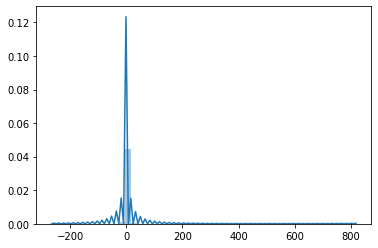

In [361]:
sns.distplot(residual)

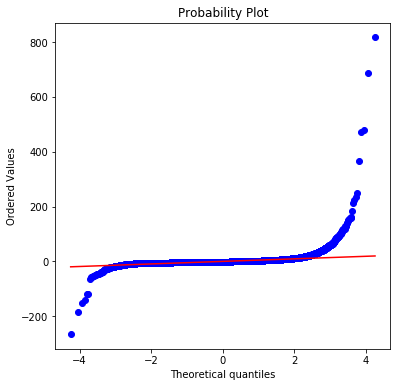

In [365]:
fig, ax = plt.subplots(figsize=(6,6))
_, (__, ___, r) = sp.stats.probplot(residual, plot=ax, fit=True)

In [366]:
np.mean(residual)

0.06648149899661233

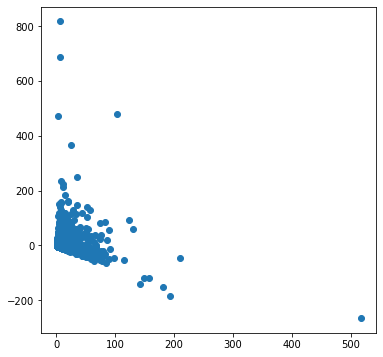

In [368]:
fig, ax = plt.subplots(figsize=(6,6))
_ = ax.scatter(y_pred, residual)

The normality of the residuals as well as the Homodeastacity seems to be violated and the OLS can not be applied. Data must be transformed

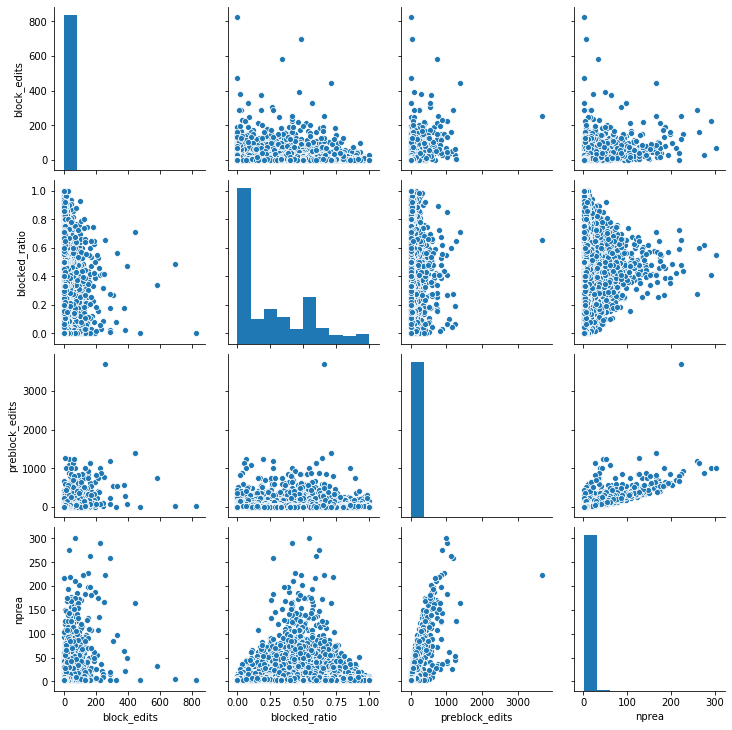

In [381]:
sns.pairplot(df)

### 2) Centralization


In [390]:
gini.columns

Index(['page_id', 'eprea', 'eposta', 'gprea', 'gposta', 'evprea', 'evposta',
       'nprea', 'nposta', 'max_pre_gini', 'max_post_gini', 'normalized_gprea',
       'normalized_gposta', 'cdelta'],
      dtype='object')

In [408]:
target_col = 'cdelta'

In [409]:
df = metrics_df[['cdelta', 'blocked_ratio', 'nprea']].dropna()

In [410]:
X = df.loc[:, df.columns != target_col].dropna()
y = df.loc[:, target_col]

In [411]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.30, 
                                                    random_state=42)

In [412]:
X_with_constant = sm.add_constant(X_train)
model = sm.OLS(y_train, X_with_constant)

In [413]:
results = model.fit()
results.params

const           -0.032003
blocked_ratio    0.013124
nprea            0.000180
dtype: float64

In [414]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 cdelta   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     4.327
Date:                Sat, 15 May 2021   Prob (F-statistic):             0.0132
Time:                        17:25:49   Log-Likelihood:                -12833.
No. Observations:               54647   AIC:                         2.567e+04
Df Residuals:                   54644   BIC:                         2.570e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0320      0.002    -16.950

In [415]:
X_test = sm.add_constant(X_test)
y_pred = results.predict(X_test)
residual = y_test - y_pred

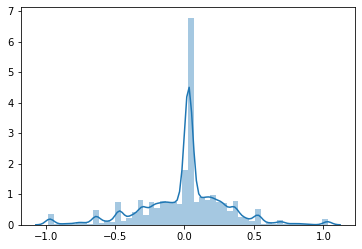

In [416]:
sns.distplot(residual)

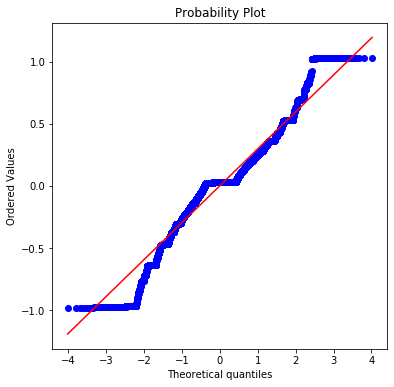

In [417]:
fig, ax = plt.subplots(figsize=(6,6))
_, (__, ___, r) = sp.stats.probplot(residual, plot=ax, fit=True)

In [418]:
np.mean(residual)

0.0013863595306392736

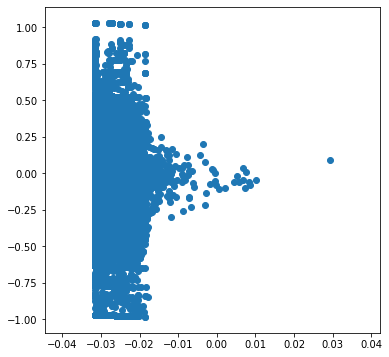

In [419]:
fig, ax = plt.subplots(figsize=(6,6))
_ = ax.scatter(y_pred, residual)

The normality of the residuals as well as the Homodeastacity seems to be violated and the OLS can not be applied. Data must be transformed

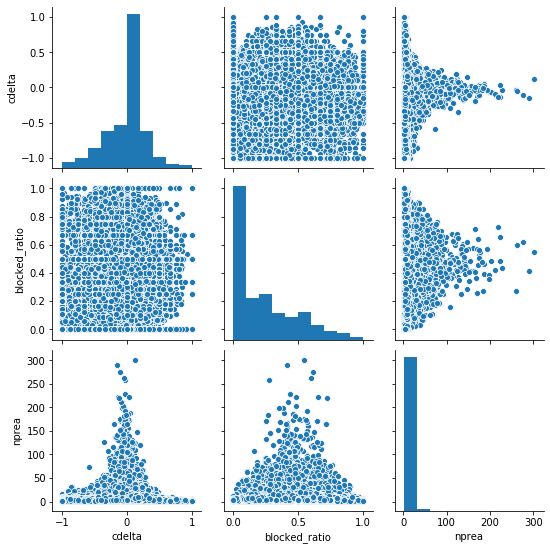

In [420]:
sns.pairplot(df)

The residuals of the Romero metrics are not normal and OLS isn't appropriate. Instead, we modify them and study the metrics on a larger level than the article level.